## Prediction with the Single-Cell Model: Without Context vs CELTIC (With Context)

In this notebook, we demonstrate the process of predicting cell features using two different models: the Single-Cell model without context and the CELTIC model with context. 

We compare predictions for two example cells—one in interphase and the other in mitosis—using both models to observe the impact of context features on prediction performance.


In [7]:
# Presets
organelle = 'microtubules'
resources_dir = '../resources'
path_single_cells = f'{resources_dir}/{organelle}/cell_images_examples'

In [ ]:
from predict import predict
import os
import pandas as pd
import numpy as np
import tifffile
from celtic.utils.functions import show_images_subplots, initialize_experiment, download_resources

def plot_examples(path_save_dir):
    entries = [f'{path_save_dir}/{entry}' for entry in os.listdir(path_save_dir)]
    dirs = [entry for entry in entries if os.path.isdir(entry)]
    images = []
    titles = []
    for dir in dirs:
        index = int(os.path.basename(dir))
        signal = tifffile.imread(f'{dir}/signal.tiff')
        target = tifffile.imread(f'{dir}/target.tiff')
        mask = tifffile.imread(f'{dir}/mask.tiff')
        prediction = np.squeeze(tifffile.imread(f'{dir}/prediction.tiff')) * mask
        z = signal.shape[0]//2
        images.extend([signal[z], target[z], prediction[z]])
        titles.extend([f'Signal ({index})', 'Target', 'Prediction'])
    show_images_subplots(shape=(len(dirs),3), images=images, titles=titles, axis_off=True, figsize=(15,8))


/home/elmalni/.conda/envs/my_janelia/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# download resources
if not os.path.exists(resources_dir):
    shared_folder_link = 'https://drive.google.com/drive/folders/1KTzb3fzwjH5ffSLtLNHuYiLiPg2p2VUf?usp=sharing'
    download_resources(shared_folder_link, os.path.dirname(resources_dir))

### Run Prediction (Without Context)

In this section, we perform prediction using the a single cell model without incorporating context features. The experiment is initialized, and the necessary arguments are set up for the prediction process. The results are saved in the specified directory. This example shows predictions for two cells: one in interphase and the other in mitosis.

In the next section, we will perform prediction using context features for comparison.


In [9]:
# initialize the experiment
path_save_dir, context_model_config = initialize_experiment(organelle, 'predict', resources_dir)

# prepare args and run prediction
args={
    'path_images_csv': f'{resources_dir}/{organelle}/metadata/test_images.csv',
    'masked': True,
    'transforms': context_model_config['transforms'],
    'path_model': f'{resources_dir}/{organelle}/models/best_model_no_context.p',
    'path_context_csv': '',
    'path_single_cells': path_single_cells,
    'context_features': [],
    'daft_embedding_factor': None,
    'daft_scale_activation': None,
    'path_save_dir': path_save_dir,
    'save_only_prediction': False,
    'selected_indices': [44, 45], # interphase and mitosis examples
    'evaluation_metrics': ['mse', 'pearsonr']
}

predict.run_prediction(**args)

100%|██████████| 2/2 [01:08<00:00, 34.20s/it]


After running the prediction, we load the evaluation results from the saved `evaluation.csv` file. The mean Pearson correlation coefficient (PCC) across all predictions is calculated and displayed. The full evaluation results, including individual cell predictions, are also printed for further analysis.

In [4]:
results = pd.read_csv(f'{path_save_dir}/evaluation.csv')
print(f'Mean PCC = {np.mean(results.pearsonr.values):.3f}')
results

Mean PCC = 0.630


,cell_index,mse,pearsonr
0,44,0.266245,0.856803
1,45,0.838397,0.402806


We visualize the predictions of the interphase and mitotic cells. The images include the bright field image, the target (ground truth), and the in silico prediction generated without context. 

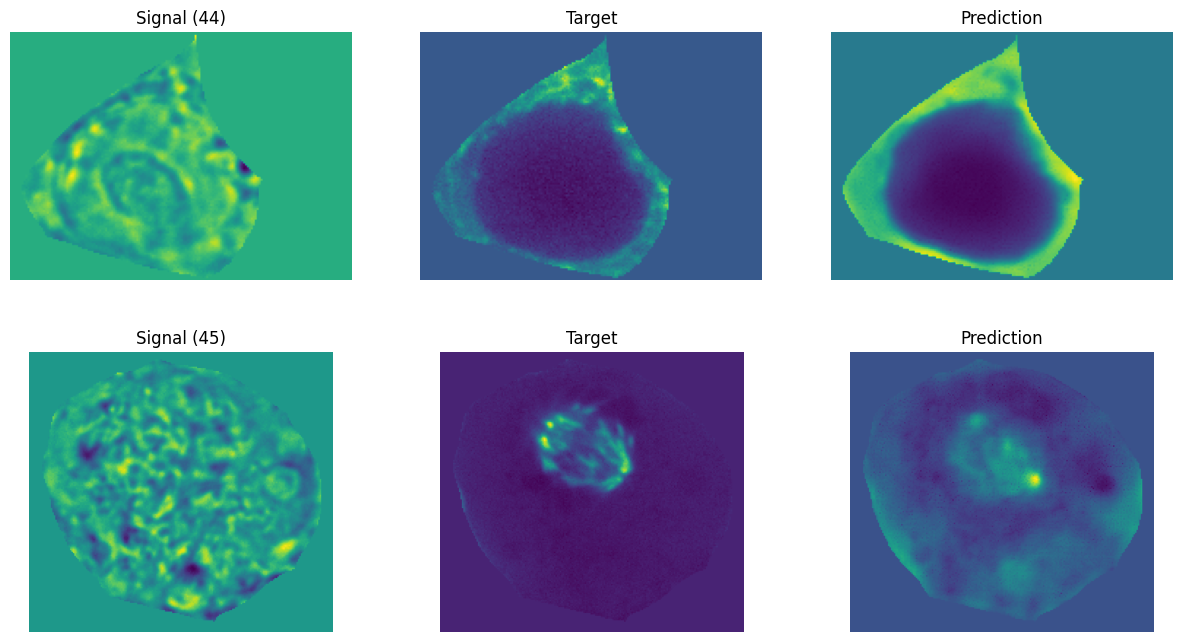

In [5]:
plot_examples(path_save_dir)

### Run Prediction (With Context)

In this section, we repeat the prediction process for the same two cells (one in interphase and one in mitosis), but this time, we use the CELTIC model with context features. The experiment is initialized, and the necessary arguments are set up for prediction, incorporating the context data alongside the image inputs. 

This allows for a direct comparison with the previous predictions made without context.


In [10]:
# initialize another experiment
path_save_dir, context_model_config = initialize_experiment(organelle, 'predict', resources_dir)

# prepare args and run prediction
args={
    'path_images_csv': f'{resources_dir}/{organelle}/metadata/test_images.csv',
    'masked': True,
    'transforms': context_model_config['transforms'],
    'path_model': f'{resources_dir}/{organelle}/models/best_model_context.p',
    'path_single_cells': path_single_cells,
    'path_context_csv': f'{resources_dir}/{organelle}/metadata/test_context.csv',
    'context_features': context_model_config['context_features'],
    'daft_embedding_factor': context_model_config['daft_embedding_factor'],
    'daft_scale_activation': context_model_config['daft_scale_activation'],
    'path_save_dir': path_save_dir,
    'save_only_prediction': False,
    'selected_indices': [44, 45],# interphase and mitosis examples
    'evaluation_metrics': ['mse', 'pearsonr']   
}

predict.run_prediction(**args)

bottleneck_dim=132
embedding factor: 4 | activation: Sigmoid()


100%|██████████| 2/2 [00:57<00:00, 28.62s/it]


In [11]:
results = pd.read_csv(f'{path_save_dir}/evaluation.csv')
print(f'Mean PCC = {np.mean(results.pearsonr.values):.3f}')
results

Mean PCC = 0.777


,cell_index,mse,pearsonr
0,44,0.330851,0.832457
1,45,0.536928,0.722345


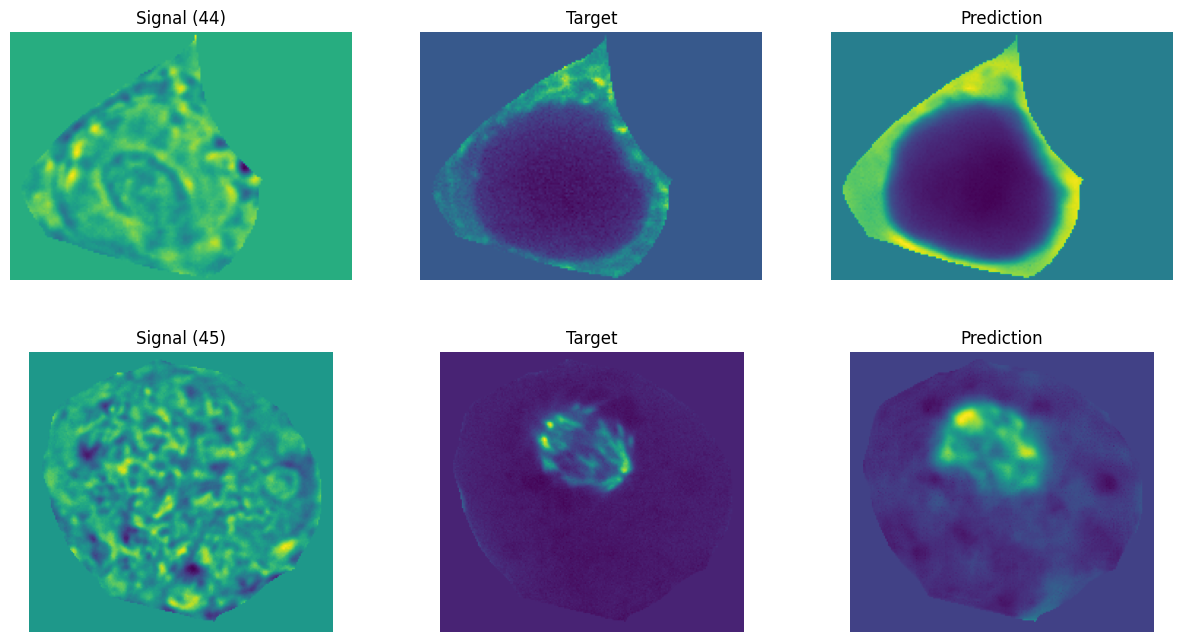

In [12]:
plot_examples(path_save_dir)